In [1]:
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import statistics as st
import networkx as nx
import matplotlib.pyplot as plt
import glob
# Python Lib POWER LAW: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777 
import powerlaw

# Input

In [2]:
networksAnalisys={}
networksAnalisys['Protein']=['HPRD','HINT','Human','ReactomeFI']
networksAnalisys['Others']=['Collaboration','Powergrid']
networksAnalisys['Synthetic']=['erdos_renyi','barabasi_albert_m2']

In [3]:
measuresDataFrames={}
measures=['degree']
for t in networksAnalisys:
    for name in networksAnalisys[t]:
        values=[]
        df=pd.DataFrame()
        for m in measures:
            path=glob.glob('inputs\\'+m+'_'+name+'.tsv')[0]
            df[m.capitalize()]=pd.read_csv(path,sep='\t')[m]

        if(name=='Human'):
            name='MINT'
        elif(name=='erdos_renyi'):
            name='Erdos-Renyi'
        elif(name=='barabasi_albert_m2'):
            name='Barabasi-Albert'
            
        measuresDataFrames[name]= df

# Degree Distribution

In [5]:
def scaleFreeMeasures(degree):    
    degree=sorted(degree,reverse=True)
    
    #Fitting with powerlaw lib #We let the lib choose the xmin
    fit = powerlaw.Fit(degree,verbose=False)
    # Comparing the distribution with a power law, and a exponential # R is the Ratio and p is the p-value
    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)    
    
    #General information
    info={}
    info['N']=len(degree) # Number of Nodes
    info['<k>']= round(st.mean(degree),2) #Average degree
    info['<k2>']= round(st.variance(degree) + st.mean(degree)**2,2) #The 2 moment of the degree
    info['Kmax']= max(degree) #Biggest hub
    
    kmin=fit.power_law.xmin #Nodes with degree < than kmin are discarded from the distribution in order the find the gamma
    gamma=fit.power_law.alpha # Degree Exponent (after xmin)  
    info['Gamma'] = round(gamma,3)
    return info       
    
def scaleFreePlotDegree(degree,name=''): 
    degree=sorted(degree,reverse=True)
    fit = powerlaw.Fit(degree,verbose=False)
    
    #Call the function to get the measures    
    info = scaleFreeMeasures(degree)
    resume = str(info).replace('{','').replace('}','').replace('\'','').replace(',',' |').replace('| Kmax','\nKmax')

    plt.title(name+'\n'+resume)  
    
    #Frequence of each value
    freq={}
    length = len(degree)
    for v in degree:
        if(v in freq):
            freq[v]+=1
        else:
            freq[v]=1            
    #Probability of a 'd' value happens
    pk={}        
    for f in freq:
        pk[f]=freq[f]/length 
    x=list(pk.keys())
    y=list(pk.values())    
    ####-------------------Probability LogLog
    
    plt.loglog(x,y,'.')
    plt.xlabel('K',fontsize=10,labelpad=-10)
    plt.ylabel(r'$p_k$',rotation = 0,fontsize=10,labelpad=-10)
    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.075, 0.45)
    plt.tick_params(axis='both', labelsize=10)    
    plt.tight_layout()
    
    
    
def scaleFreePlotDegreeCum(degree,name=''): 
    degree=sorted(degree,reverse=True)
    plt.title(name)  
    #Frequence of each value
    freq={}
    length = len(degree)
    for v in degree:
        if(v in freq):
            freq[v]+=1
        else:
            freq[v]=1            
    #Probability of a 'd' value happens
    pk={}        
    for f in freq:
        pk[f]=freq[f]/length 
    x=list(pk.keys())
    y=list(pk.values())    
    
    #Cumulative Probability
    xAxes=[]
    yAxes=[]
    cum=0
    for k,v in pk.items():
        cum+=v
        xAxes.append(k)
        yAxes.append(cum)
        
    plt.loglog(xAxes,yAxes,'.')
    plt.xlabel('K',fontsize=10,labelpad=-10)
    plt.ylabel(r'$p_k$',rotation = 0,fontsize=10,labelpad=-10)
    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.075, 0.55)
    plt.tick_params(axis='both', labelsize=10)    
    plt.tight_layout()

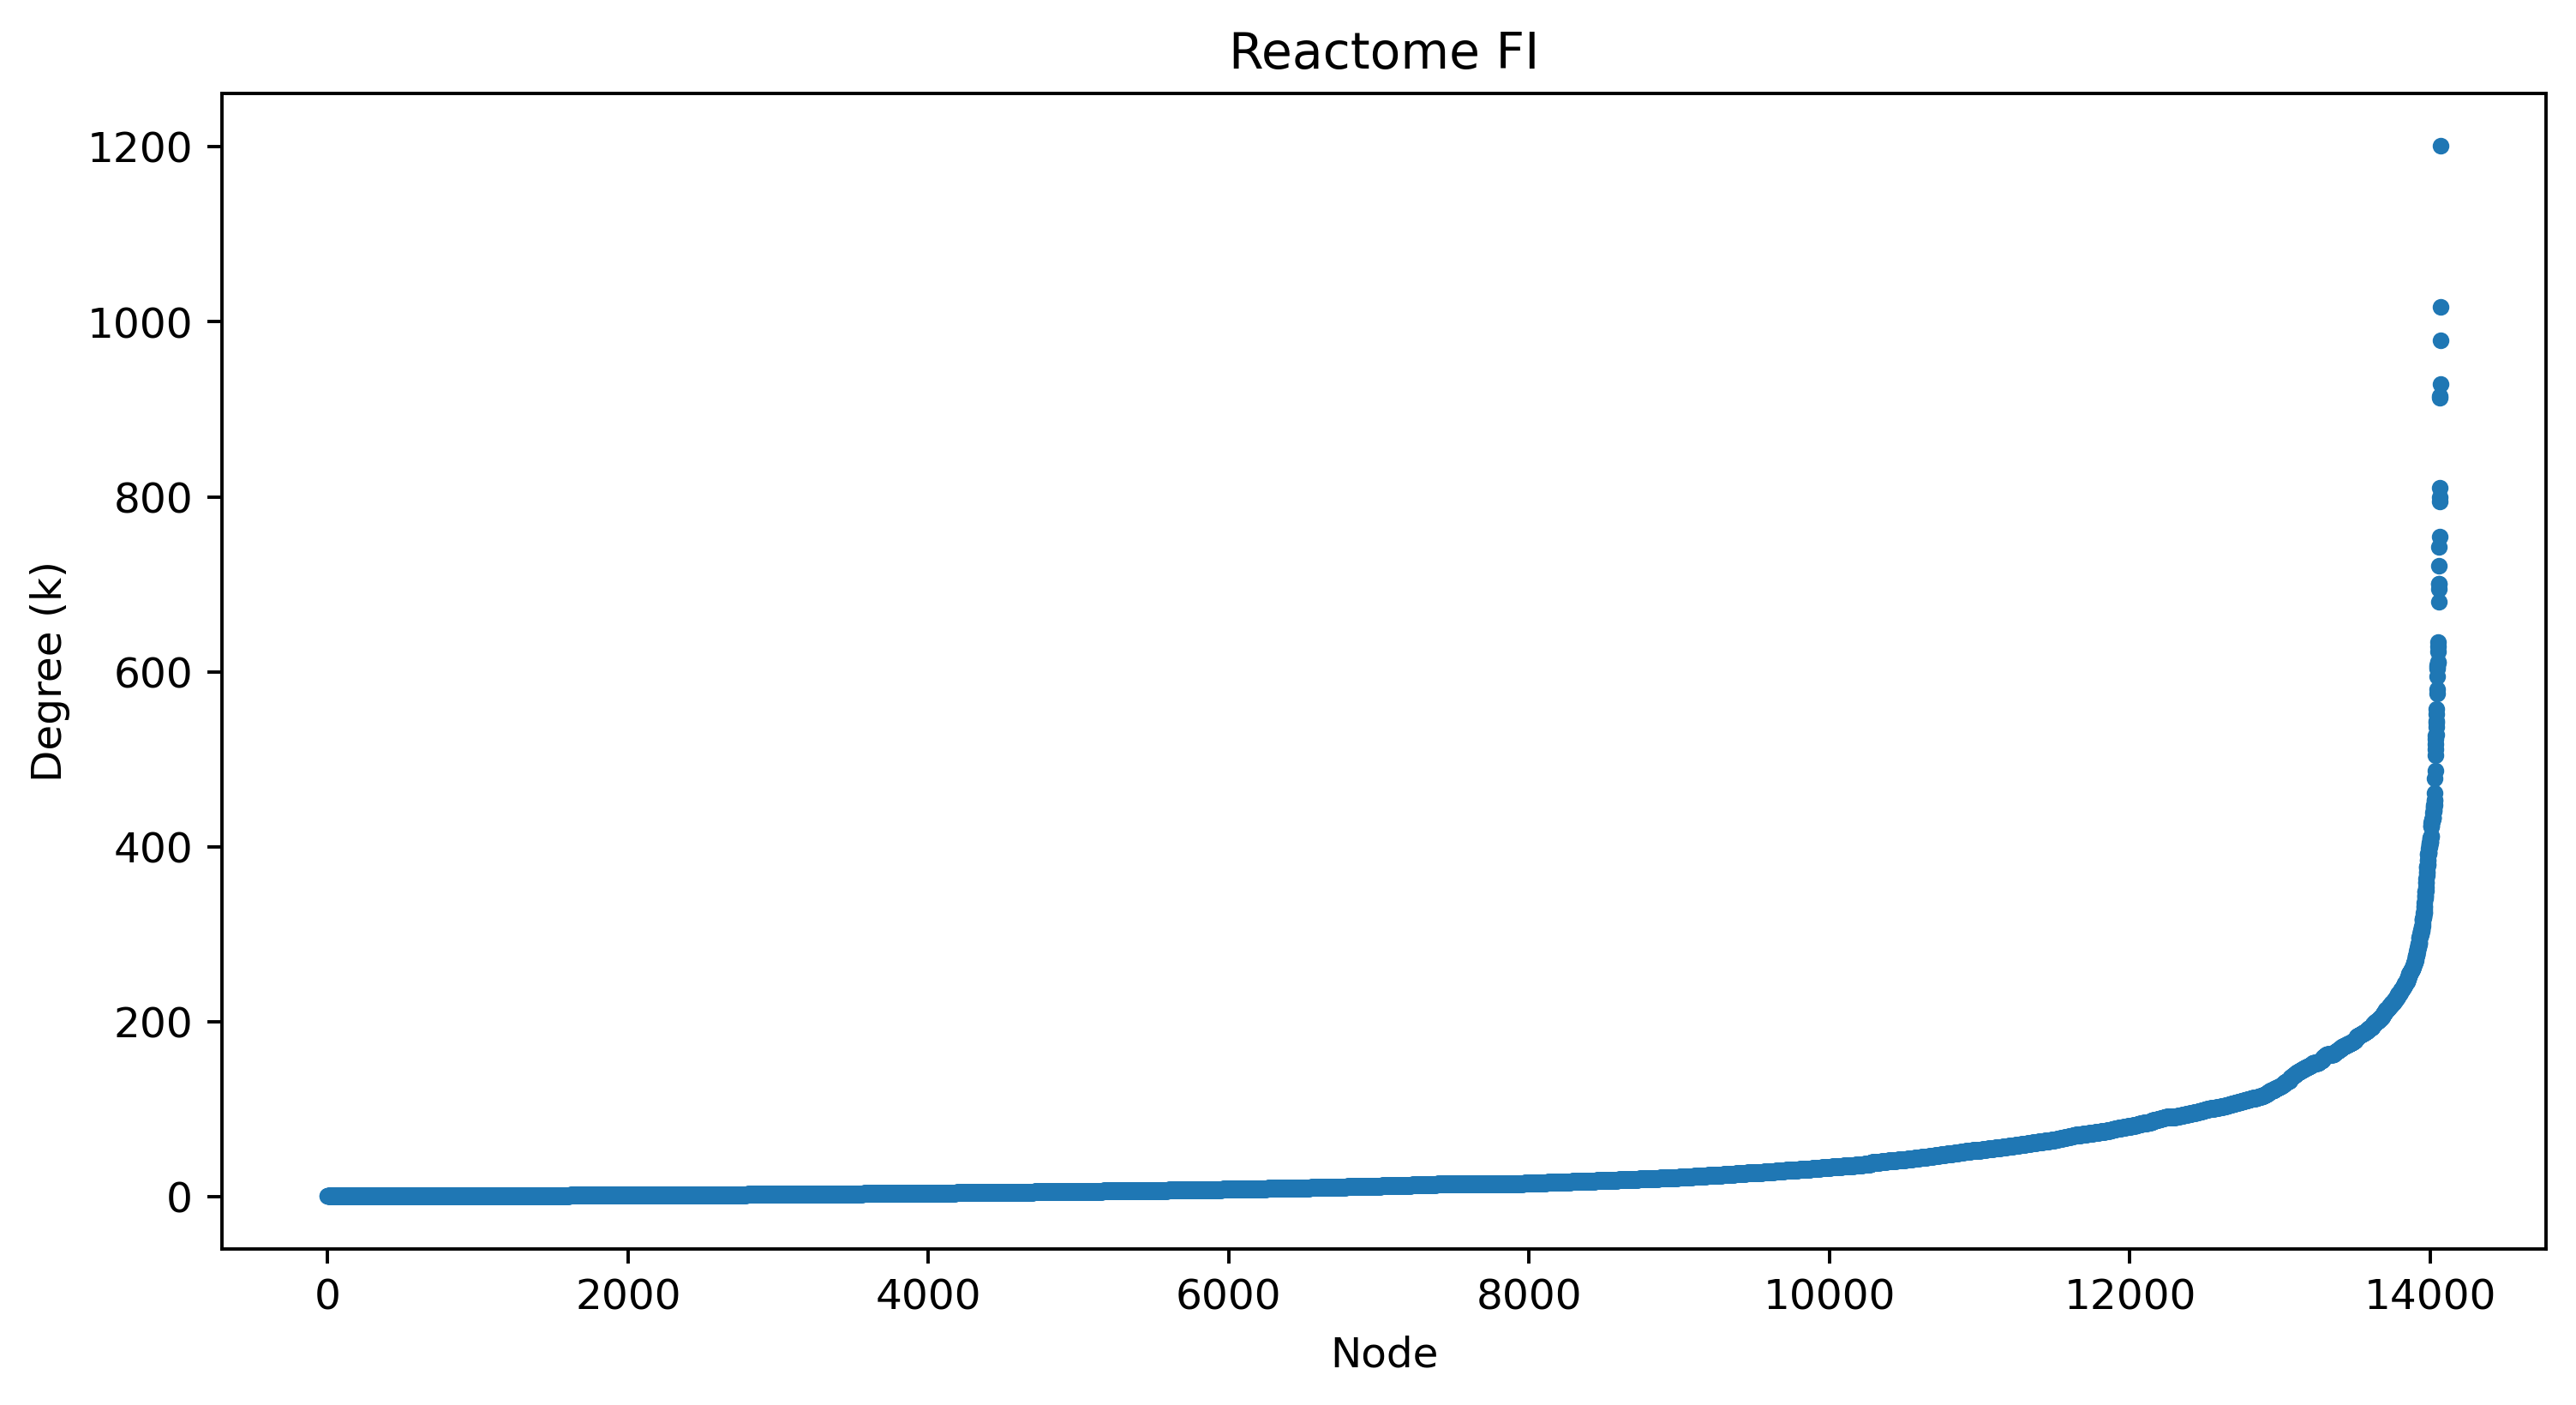

In [13]:
plt.figure(figsize=(10,5),dpi=350)
plt.plot(sorted(measuresDataFrames['ReactomeFI']['Degree']),'.')
plt.xlabel('Node')
plt.ylabel('Degree (k)')
plt.title('Reactome FI')
plt.show()

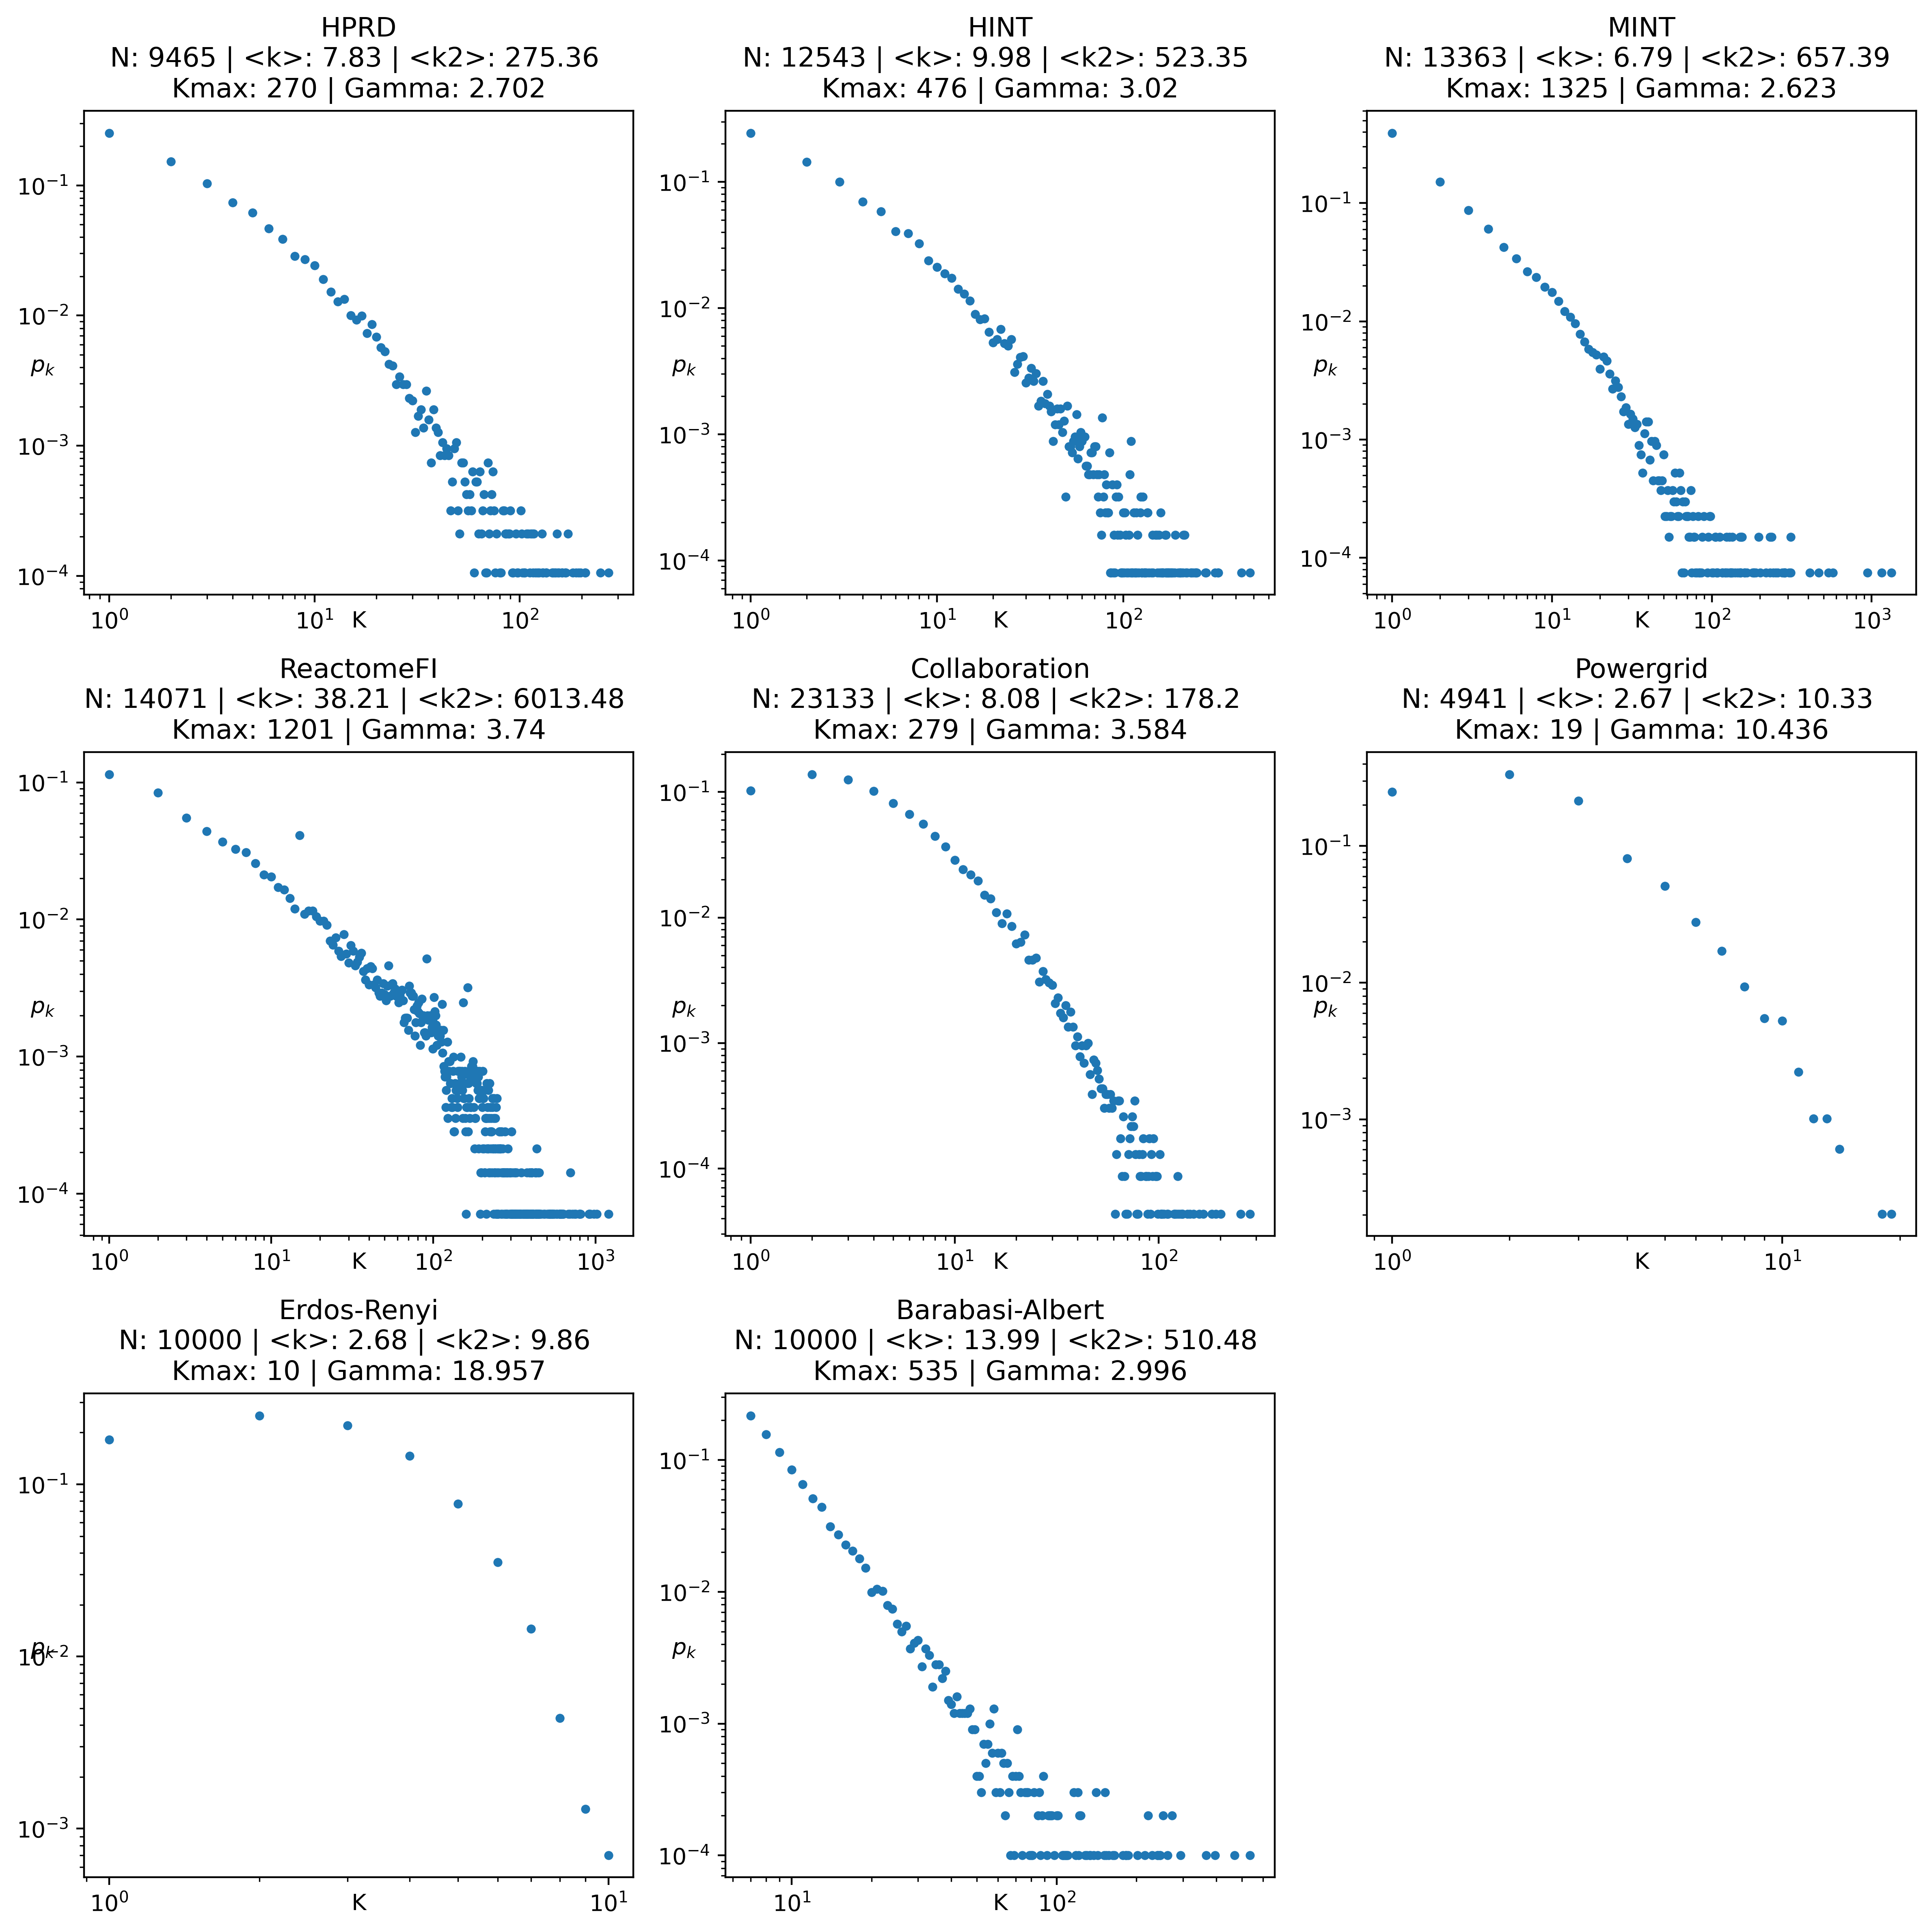

In [15]:
plt.figure(figsize=(12,12),dpi=400)
for i,net in enumerate(measuresDataFrames):
    plt.subplot(3,3,i+1)
    scaleFreePlotDegree(measuresDataFrames[net]['Degree'],net)
plt.tight_layout()
plt.savefig("ouput/2.2.1 Degree Distribution.png", format='png', dpi=550)
plt.savefig("ouput/2.2.1 Degree Distribution.pdf", format='pdf')
plt.show()

In [20]:
line=0
col=0
fig, ax = plt.subplots(3,3,figsize=(20, 15),dpi=550)
for i,net in enumerate(measuresDataFrames):
    degree=measuresDataFrames[net]['Degree']
    name=net
    degree=sorted(degree,reverse=True)
    fit = powerlaw.Fit(degree,verbose=False)
    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    #General information
    info={}
    info['N']=len(degree) # Number of Nodes
    info['<k>']= round(st.mean(degree),2) #Average degree
    info['<k2>']= round(st.variance(degree) + st.mean(degree)**2,2) #The 2 moment of the degree
    info['Kmax']= max(degree) #Biggest hub    
    kmin=fit.power_law.xmin #Nodes with degree < than kmin are discarded from the distribution in order the find the gamma
    gamma=fit.power_law.alpha # Degree Exponent (after xmin)  
    info['Gamma'] = round(gamma,2)
    info['kMinCut'] = kmin    
    info['Ratio'] = round(R,2)
    info['pValue'] = round(p,4)

    resume = str(info).replace('{','').replace('}','').replace('\'','').replace(',',' |').replace('| Gamma','\nGamma')
   
    plt.sca(ax[line,col])
    ax[line,col] = fit.plot_pdf(color='b', linewidth=2)
    fit.power_law.plot_pdf(color='g', linestyle='--', ax=ax[line,col])
    ax[line,col].set_title(name+'\n'+resume,fontsize=14)  
    if (i+1)%3==0:
        line+=1
        col=0
    else:
        col+=1
        
fig.delaxes(ax[line,col])
fig.tight_layout()
plt.savefig("ouput/2.2.1 Degree Distribution PowerLawLib.png", format='png', dpi=550)
plt.savefig("ouput/2.2.1 Degree Distribution PowerLawLib.pdf", format='pdf')

plt.show()

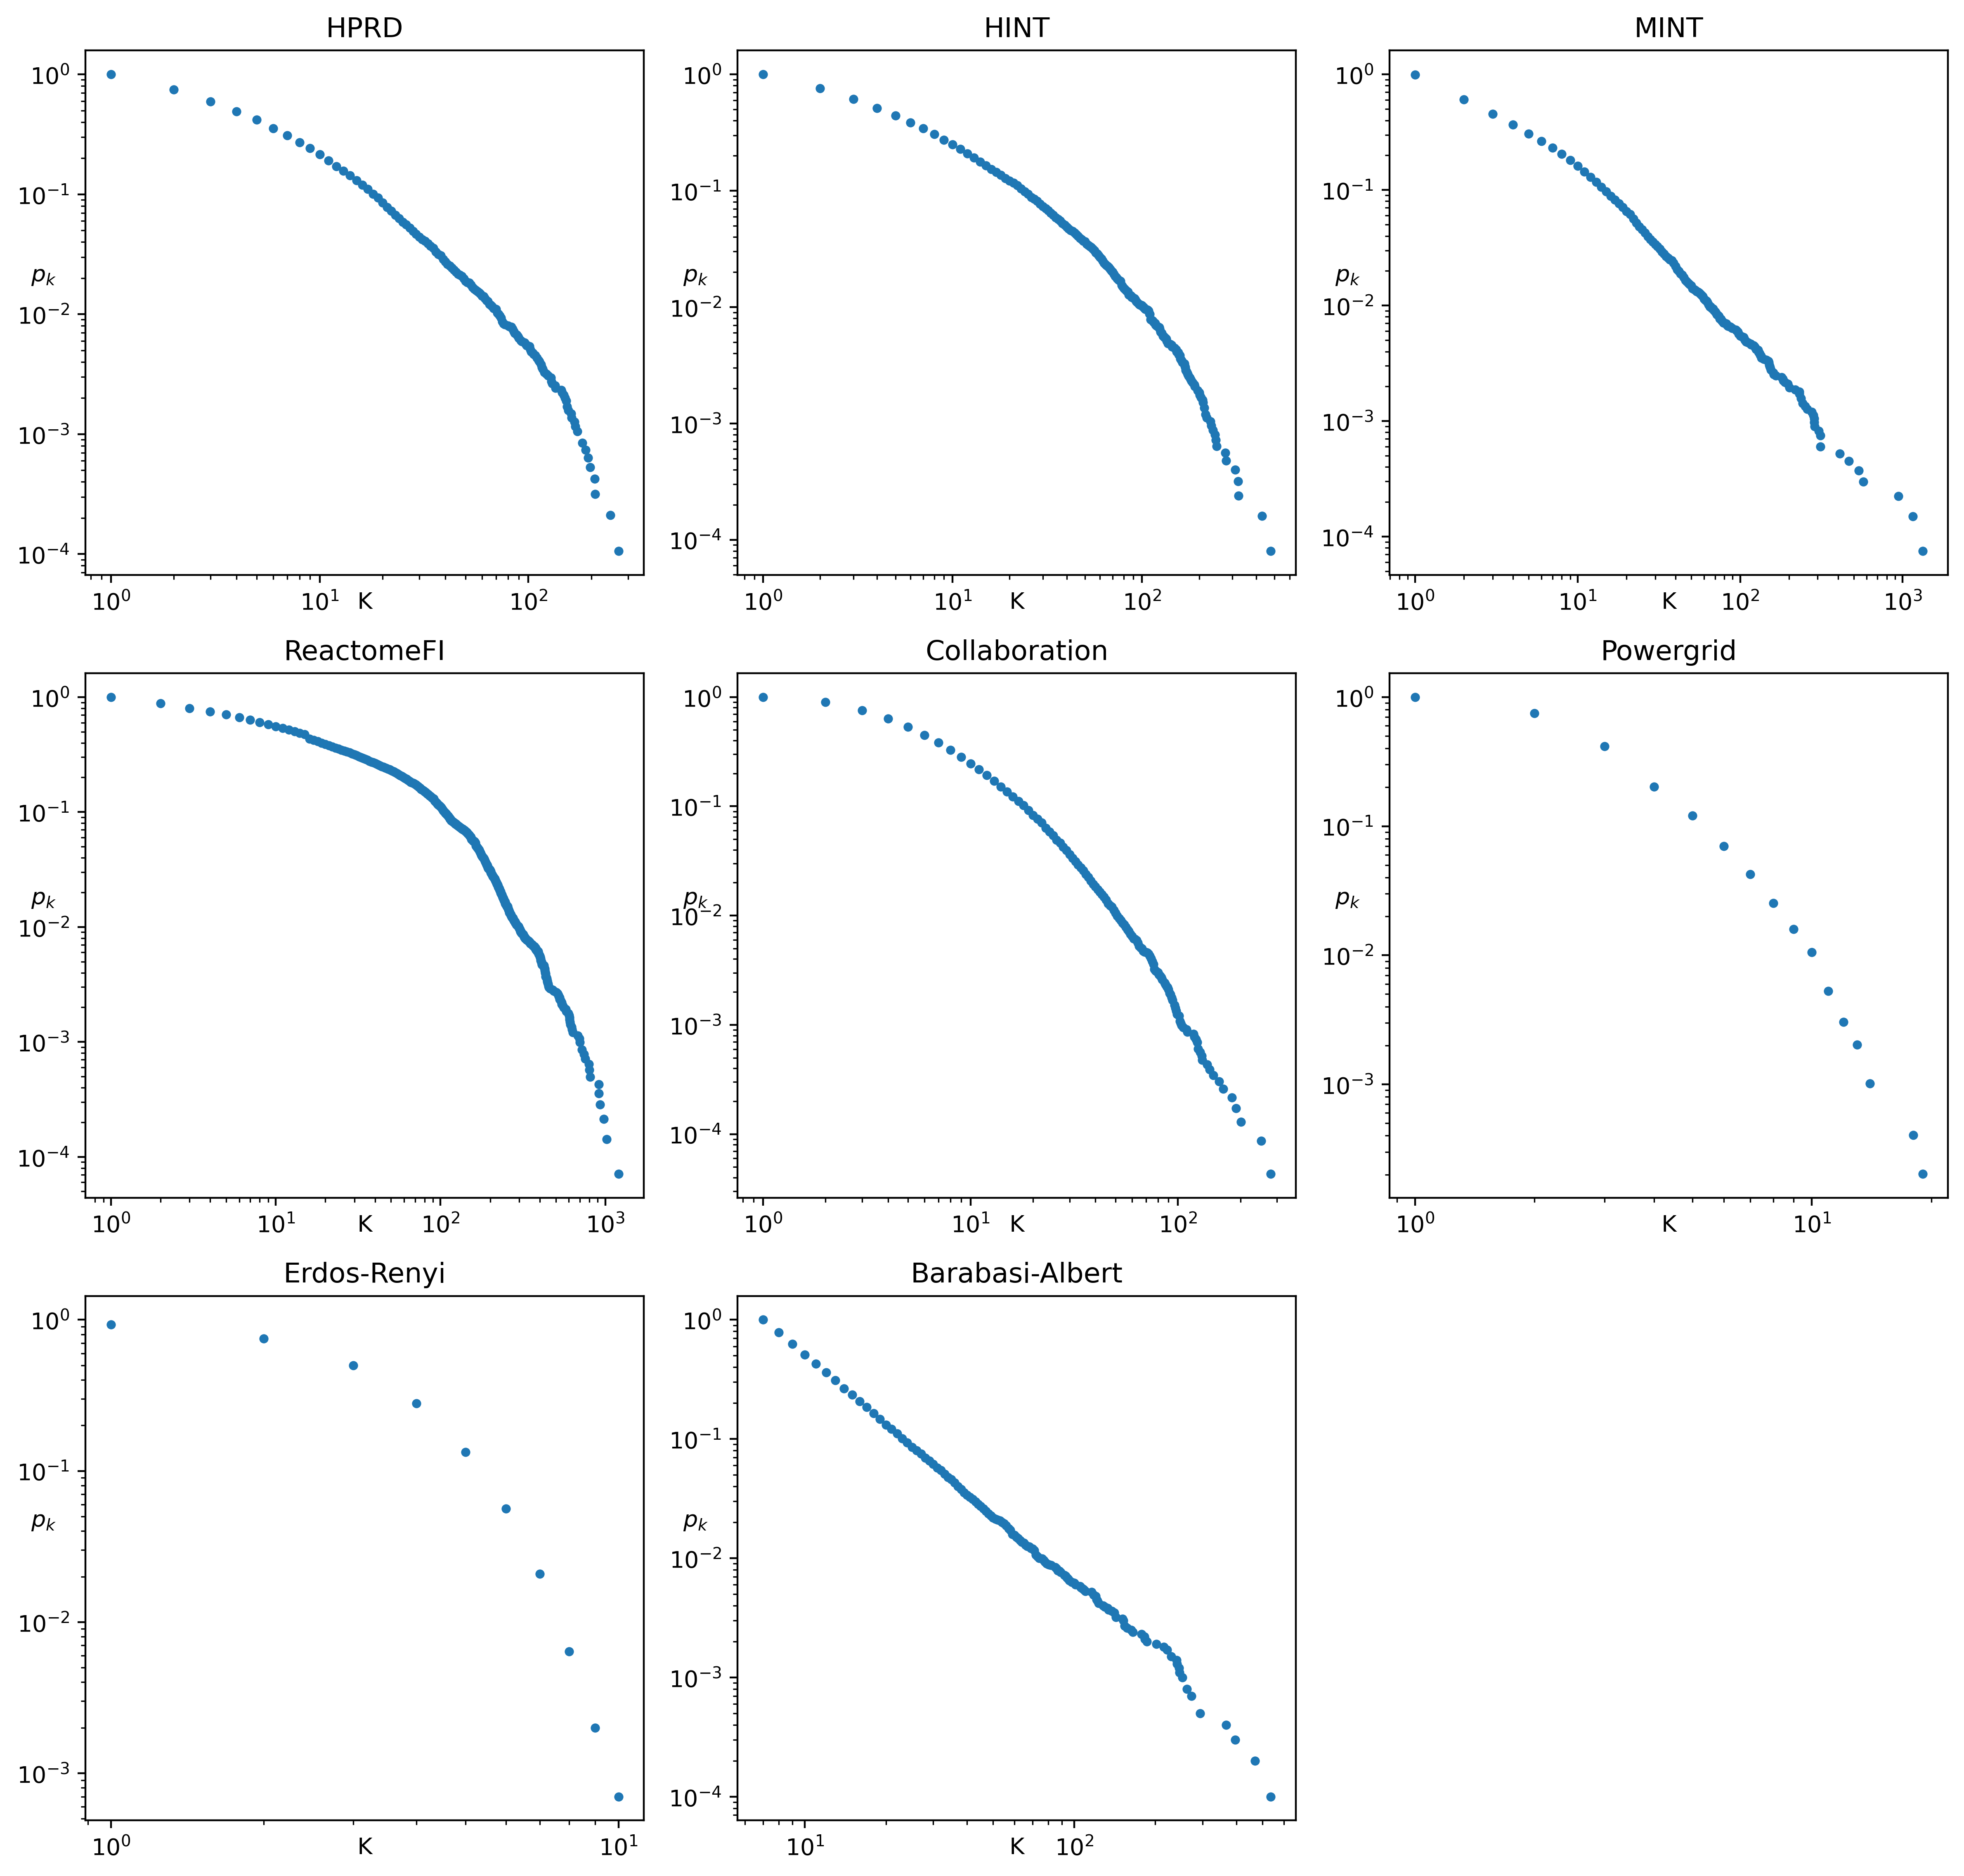

In [7]:
plt.figure(figsize=(12,15),dpi=400)
for i,net in enumerate(measuresDataFrames):
    plt.subplot(4,3,i+1)
    scaleFreePlotDegreeCum(measuresDataFrames[net]['Degree'],net)
plt.tight_layout()
plt.show()

# Ratio of Random Networks

In [31]:
G1=nx.erdos_renyi_graph(10000,0.001)
G1.name='Random 1'
print(nx.info(G1))

Name: Random 1
Type: Graph
Number of nodes: 10000
Number of edges: 49748
Average degree:   9.9496


In [28]:
G1=nx.erdos_renyi_graph(10000,0.001)
G1.name='Random 1'
print(nx.info(G1))

G2=nx.erdos_renyi_graph(10000,0.005)
G2.name='Random 2'
print(nx.info(G2))

G3=nx.erdos_renyi_graph(10000,0.01)
G3.name='Random 3'
print(nx.info(G3))

Name: Random 1
Type: Graph
Number of nodes: 10000
Number of edges: 49696
Average degree:   9.9392
Name: Random 2
Type: Graph
Number of nodes: 10000
Number of edges: 250088
Average degree:  50.0176
Name: Random 3
Type: Graph
Number of nodes: 10000
Number of edges: 499487
Average degree:  99.8974


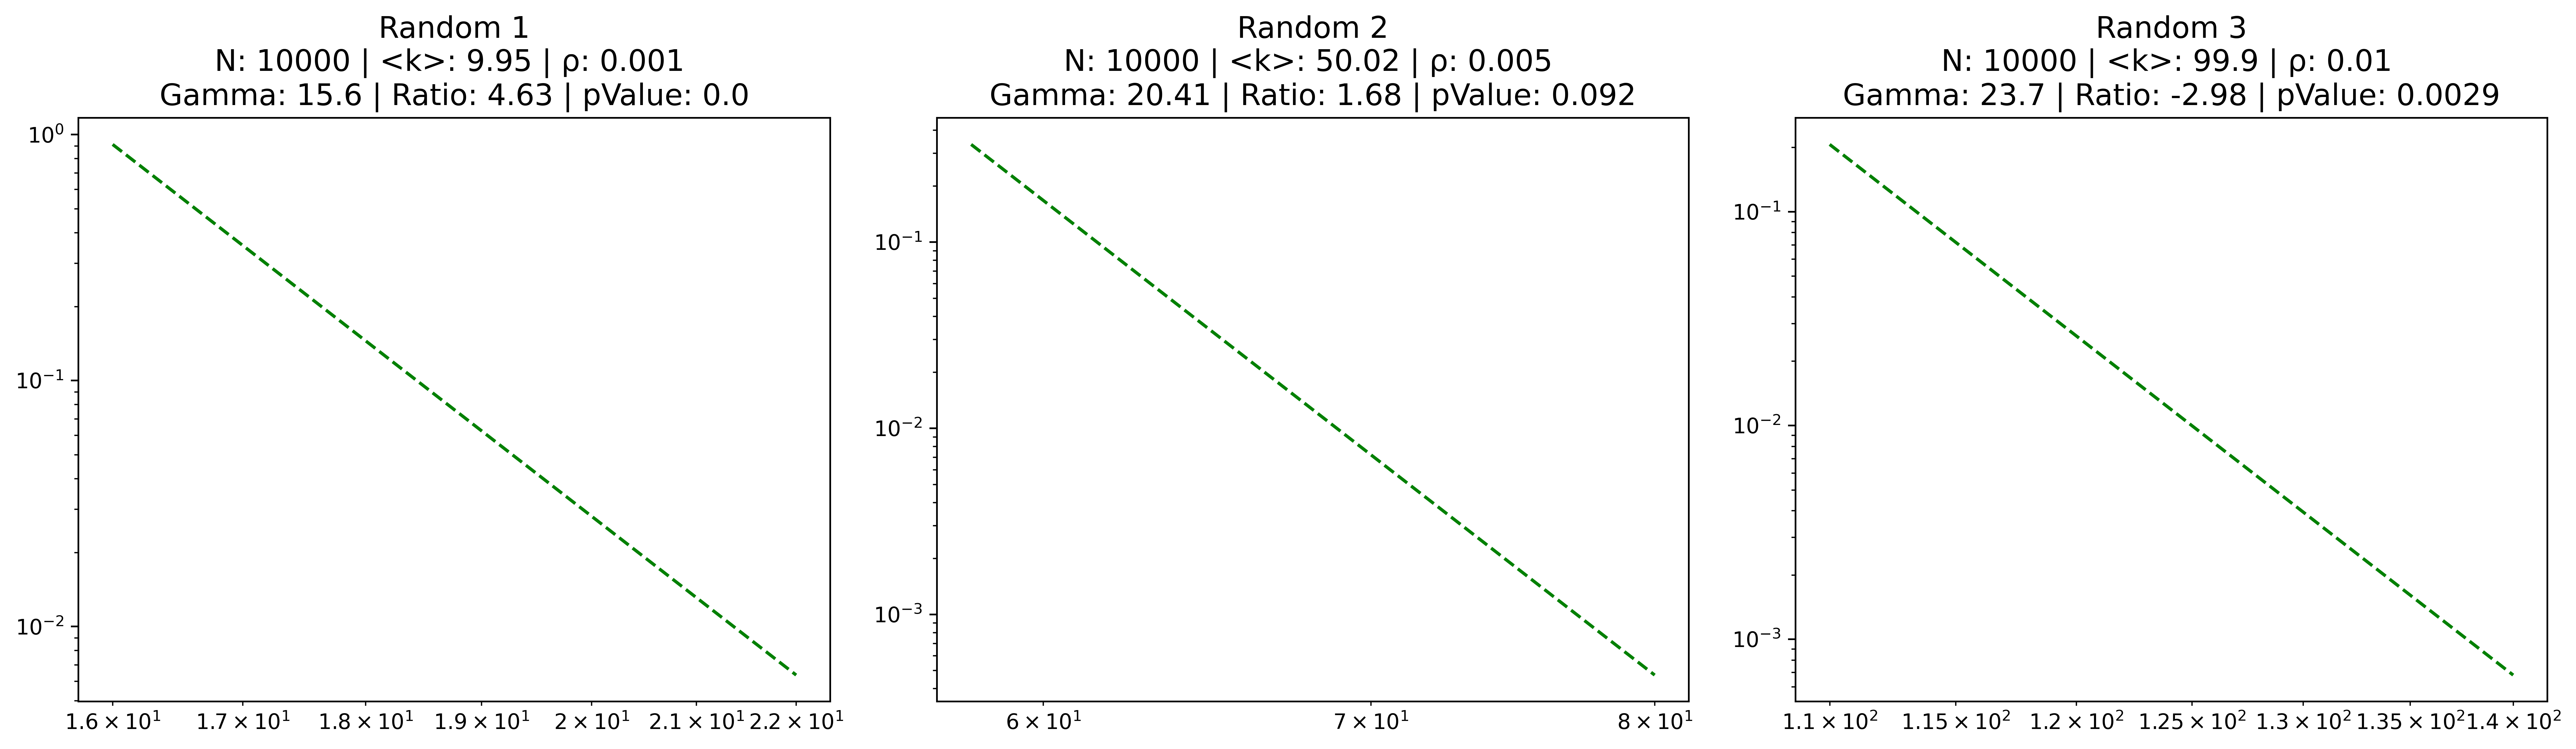

In [32]:
line=0
col=0
fig, ax = plt.subplots(1,3,figsize=(17,5),dpi=550)
for i,network in enumerate([G1,G2,G3]):
    degree=dict(nx.degree(network)).values()
    name=network.name
    degree=sorted(degree,reverse=True)
    fit = powerlaw.Fit(degree,verbose=False)
    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    #General information
    info={}
    info['N']=len(degree) # Number of Nodes
    info['<k>']= round(st.mean(degree),2) #Average degree
    info['ρ']= round(nx.density(network),3) #Average degree
    kmin=fit.power_law.xmin #Nodes with degree < than kmin are discarded from the distribution in order the find the gamma
    gamma=fit.power_law.alpha # Degree Exponent (after xmin)  
    info['Gamma'] = round(gamma,2)
    info['Ratio'] = round(R,2)
    info['pValue'] = round(p,4)

    resume = str(info).replace('{','').replace('}','').replace('\'','').replace(',',' |').replace('| Gamma','\nGamma')
   
    plt.sca(ax[col])
    ax[col] = fit.plot_pdf(color='b', linewidth=2)
    fit.power_law.plot_pdf(color='g', linestyle='--', ax=ax[col])
    ax[col].set_title(name+'\n'+resume,fontsize=14)  
    col+=1
        

fig.tight_layout()
# plt.savefig("ouput/2.2.1 Degree Distribution PowerLawLib Ratio 1.png", format='png', dpi=550)
# plt.savefig("ouput/2.2.1 Degree Distribution PowerLawLib Ratio 1.pdf", format='pdf')

plt.show()

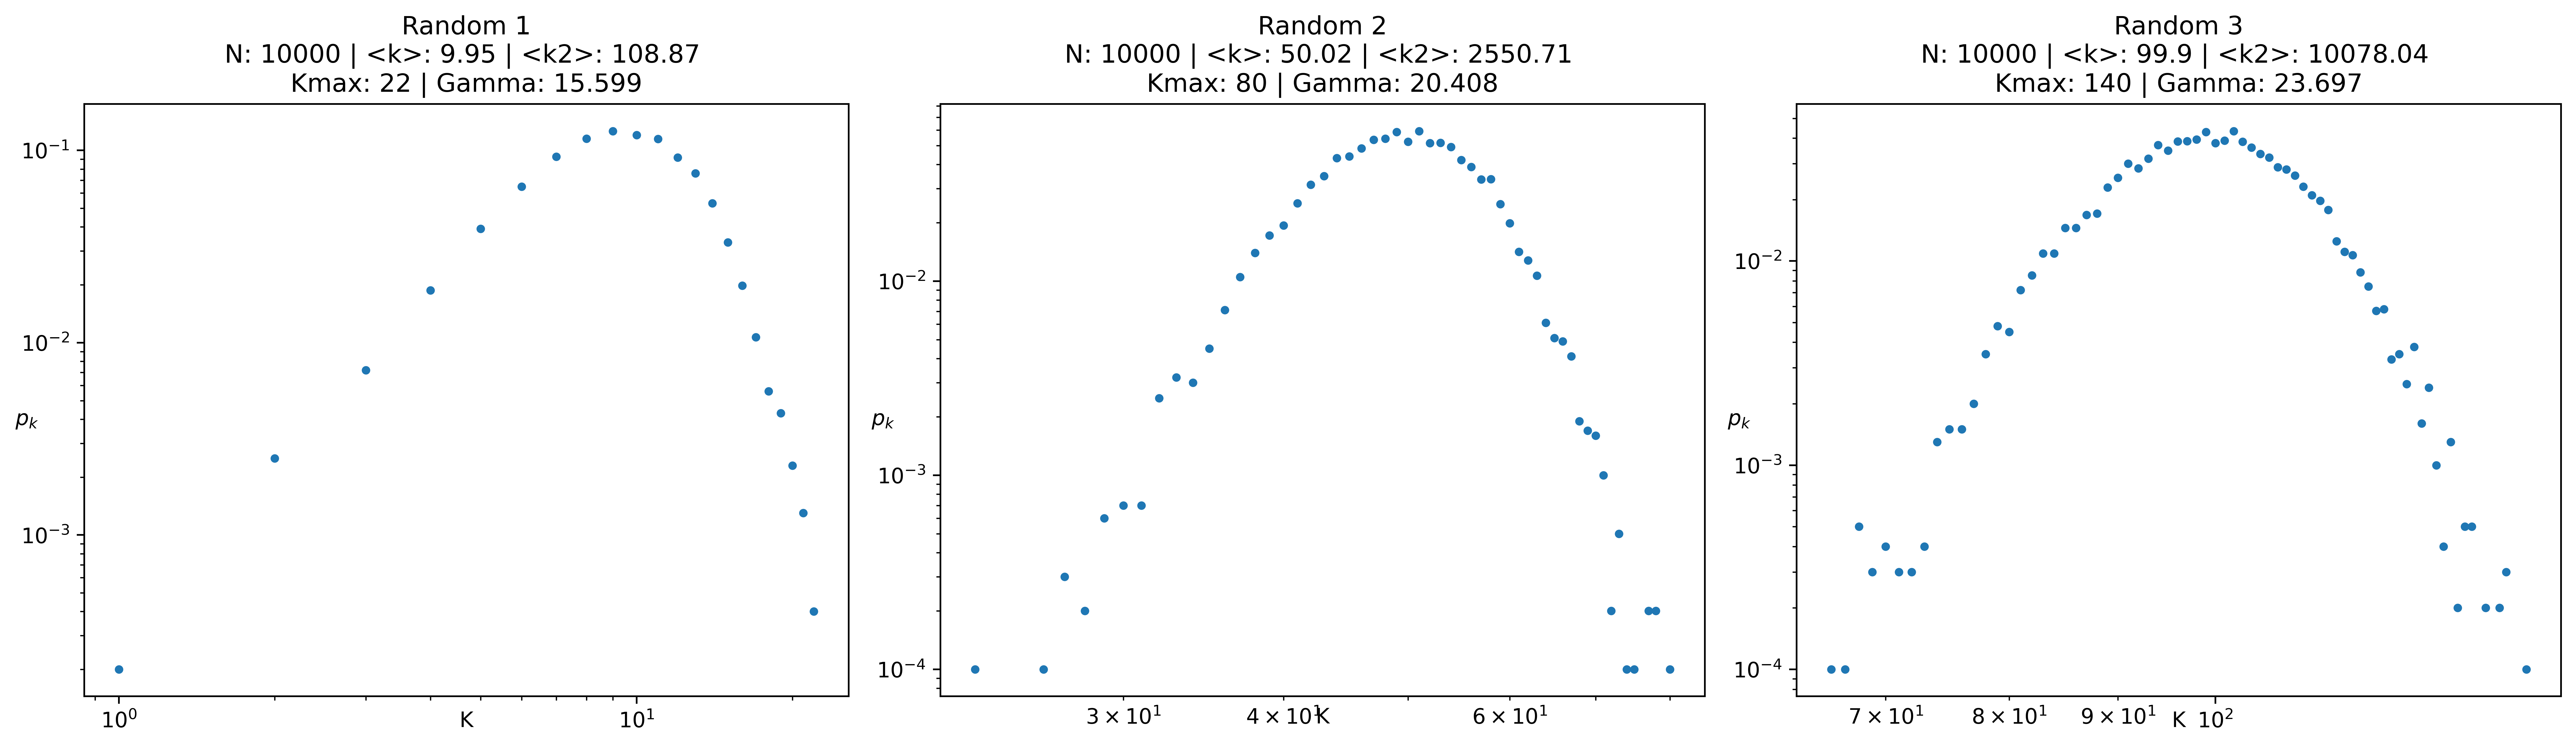

In [33]:
fig, ax = plt.subplots(1,3,figsize=(17,5),dpi=550)
for i,network in enumerate([G1,G2,G3]):
    degree=dict(nx.degree(network)).values()
    name=network.name
    plt.subplot(1,3,i+1)
    scaleFreePlotDegree(degree,name)
plt.tight_layout()
# plt.savefig("ouput/2.2.1 Degree Distribution.png", format='png', dpi=550)
# plt.savefig("ouput/2.2.1 Degree Distribution.pdf", format='pdf')
plt.show()